In [1]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


/home/akshara/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
100%|██████████| 9.91M/9.91M [00:10<00:00, 976kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 112kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 642kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.05MB/s]


In [2]:
import numpy as np

def flatten_dataset(dataset):
    data = np.array([np.array(img[0]).flatten() for img in dataset])
    labels = np.array([img[1] for img in dataset])
    return data, labels

train_data, train_labels = flatten_dataset(mnist_train)


In [13]:
def uniform_sample(data, labels, samples_per_class=100):
    sampled_data = []
    sampled_labels = []
    for digit in range(10):
        idx = np.where(labels == digit)[0]
        chosen = np.random.choice(idx, samples_per_class, replace=False)
        sampled_data.append(data[chosen])
        sampled_labels.append(labels[chosen])
    return np.concatenate(sampled_data), np.concatenate(sampled_labels)

sampled_data, sampled_labels = uniform_sample(train_data, train_labels, samples_per_class=100)


In [14]:
mean_vector = np.mean(sampled_data, axis=0)
centered_data = sampled_data - mean_vector


In [15]:
covariance_matrix = np.cov(centered_data, rowvar=False)


In [16]:
# Using np.linalg.eigh for a symmetric matrix (covariance matrix)
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]



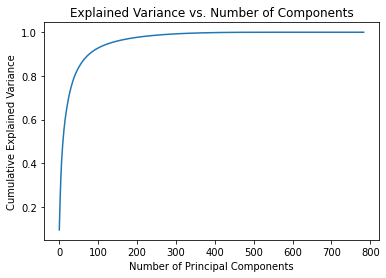

In [17]:
explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance)

import matplotlib.pyplot as plt
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


The first few principal components typically capture most of the variance in the data

After a certain number of components(around 150), the curve flattens out. Adding more components beyond that point adds relatively little extra explained variance. 

Hence, You can choose a smaller number of components (somewhere before the curve flattens) to reduce dimensionality while still retaining most of the original data’s variance.

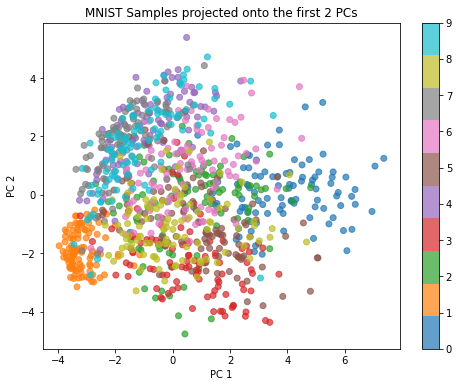

In [18]:
pc_2 = eigenvectors[:, :2]
projected_2d = centered_data.dot(pc_2)
plt.figure(figsize=(8,6))
plt.scatter(projected_2d[:, 0], projected_2d[:, 1], c=sampled_labels, cmap='tab10', alpha=0.7)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('MNIST Samples projected onto the first 2 PCs')
plt.colorbar()
plt.show()


Digit 1 is well clustered separately, 3 8 5 are all mixed implying the first PCs are not sufficent to differentiate them.
There is more variance along PC 1 than 2, which is expected in the PCA method as it has the highest eigen value.

In [19]:
idx_samples = np.random.choice(sampled_data.shape[0], 5, replace=False)
original_images = sampled_data[idx_samples]


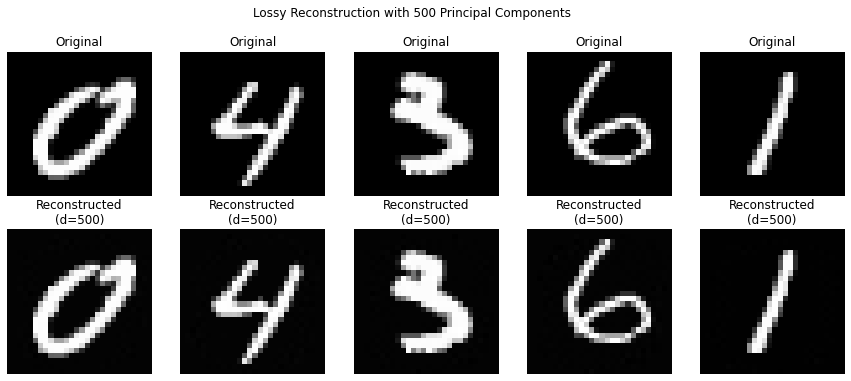

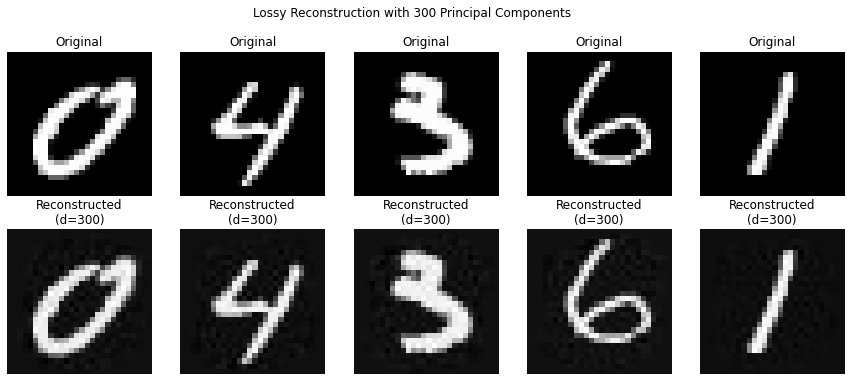

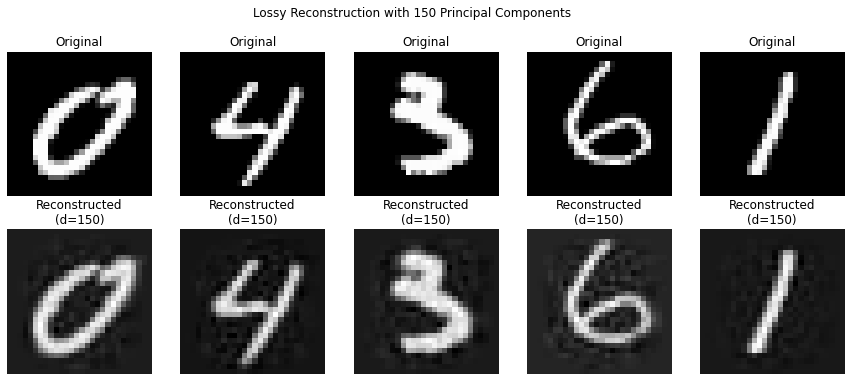

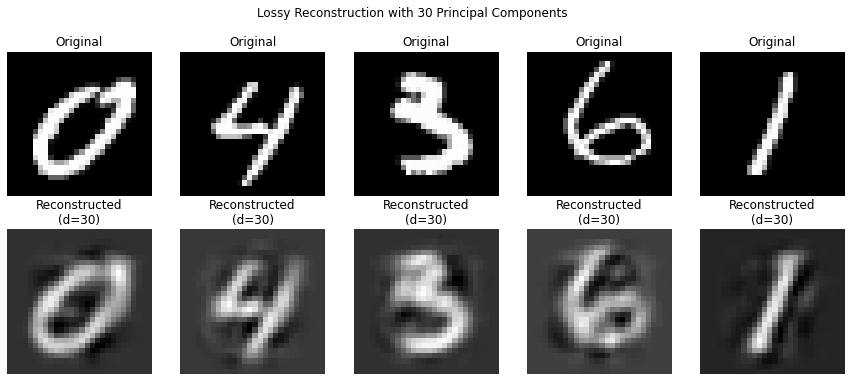

In [20]:
for d in [500, 300, 150, 30]:
    eigenvectors_d = eigenvectors[:, :d]
    projected_d = centered_data.dot(eigenvectors_d)

    reconstructed_d = projected_d.dot(eigenvectors_d.T) + mean_vector
    reconstructed_samples = reconstructed_d[idx_samples]
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axes[0, i].imshow(original_images[i].reshape(28,28), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(reconstructed_samples[i].reshape(28,28), cmap='gray')
        axes[1, i].set_title(f'Reconstructed\n(d={d})')
        axes[1, i].axis('off')
    plt.suptitle(f'Lossy Reconstruction with {d} Principal Components')
    plt.show()



These images demonstrate the information present along various Principal components. Preserving 500 PCs gives a very high resolution reconstruction, while reconstructing using lesser dimensions/components leads to lossy reconstruction and blurry images signifying the information present in the components. Also we can see that digit 1 is still clearer because it's information stored in first few components. We also notice the sudden increase in loss while reconstructing the image which is explained/suggested by the explaied variv=ncs vs components curve.

In [21]:
train_indices = np.random.choice(train_data.shape[0], 40000, replace=False)
X_train = train_data[train_indices]
y_train = train_labels[train_indices]
# For test set
X_test, y_test = flatten_dataset(mnist_test)


In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

mlp_original = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
mlp_original.fit(X_train, y_train)
y_pred = mlp_original.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Original Data -> Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Original Data -> Accuracy: 0.9751, Precision: 0.9752365845025299, Recall: 0.9751


/home/akshara/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
def compute_pca(X, d):
    # Centering
    mean_X = np.mean(X, axis=0)
    X_centered = X - mean_X
    # Covariance matrix and eigen-decomposition
    cov_X = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_X)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_idx]
    eigenvectors_d = eigenvectors[:, :d]
    # Projection
    X_reduced = X_centered.dot(eigenvectors_d)
    return X_reduced, mean_X, eigenvectors_d

# For each dimensionality setting
results = {}
for d in [500, 300, 150, 30]:
    X_train_pca, mean_train, eigenvectors_d = compute_pca(X_train, d)
    # Transform test data: center using train mean and project onto the same eigenvectors
    X_test_centered = X_test - mean_train
    X_test_pca = X_test_centered.dot(eigenvectors_d)
    
    mlp_pca = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
    mlp_pca.fit(X_train_pca, y_train)
    y_pred_pca = mlp_pca.predict(X_test_pca)
    
    acc = accuracy_score(y_test, y_pred_pca)
    prec = precision_score(y_test, y_pred_pca, average='weighted')
    rec = recall_score(y_test, y_pred_pca, average='weighted')
    
    results[d] = {'accuracy': acc, 'precision': prec, 'recall': rec}
    print(f"PCA Dimension {d} -> Accuracy: {acc}, Precision: {prec}, Recall: {rec}")


/home/akshara/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


PCA Dimension 500 -> Accuracy: 0.97, Precision: 0.9700338684681712, Recall: 0.97


/home/akshara/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


PCA Dimension 300 -> Accuracy: 0.9727, Precision: 0.9727116739966132, Recall: 0.9727


/home/akshara/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


PCA Dimension 150 -> Accuracy: 0.9735, Precision: 0.9735131970140068, Recall: 0.9735
PCA Dimension 30 -> Accuracy: 0.9753, Precision: 0.9753078379451552, Recall: 0.9753


/home/akshara/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


A slight increase in accuracy is observed with dimensionality reduction, this is likely because there is a lot of noise and redundant information in higher dimensions. Removing them prevented the model from overfitting, thus delivering higher accuracy

Computing Distances in higher dimensions is computationally very expensive. dimensionality reduction using PCA helps preserve most of the information in the original set of dimensions (by removing the correlated dimensions) while reducing the number of dimensions. This improves the model training speed while maintaining acceptable accuracy

Cases Where PCA Might Not Be Effective
Nonlinear Data Structures:
PCA is a linear method. If the correlation between dimensions is non linear PCA might not capture the structure affectively reducing the efficiency of PCA.

Intrinsic High Dimensionality:
If the data’s true structure is inherently high-dimensional—meaning that the important information is spread across many dimensions—then reducing dimensions might lead to significant loss of important information.

Sparse or Categorical Data:
PCA works best on continuous data with strong linear correlations. In datasets where features are sparse, binary, or categorical, linear relations might not exist leading to loss of information. Also in categorical data, there will be a lot of variance in the categorical dimension due to which PCA might wrongly prioritise that dimension

#### PCA assumes that the directions of maximum variance are the most informative. Is this always true? Provide an example where this assumption might fail.
No.
In addition the above example of categorical data, this assumption fails if noise in the data has more variance than actually informative components.(This can be the case in image classification)